# CMSC 636, HW4: Deep Restricted Boltzman Machine on MNIST

In [1]:
import numpy as np
import tensorflow as tf
from types import SimpleNamespace

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

## 1. Load MNIST


In [2]:
# load mnist dataset with labels encoded as one-hot vectors
class Dataset():
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.epochs = 0

    def shuffle(self):
        perm = np.arange(self.data[0].shape[0])
        np.random.shuffle(perm)
        self.data = tuple(datai[perm] for datai in self.data)
    
    def next_batch(self, batch_size):
        start = self.index
        end = self.index + batch_size
        if end > self.data[0].shape[0]:
            self.epochs += 1
            self.shuffle()
            self.index, start = 0, 0
            end = batch_size
        self.index = end
        return tuple(datai[start:end, ...] for datai in self.data)
            
def load_mnist():
    def preprocess(data, labels, num_classes):
        # flatten images
        data = data.astype(np.float32)/255.0
        data = np.reshape(data, [data.shape[0], -1])
        # one hot encoding
        num_labels = labels.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels.ravel()] = 1
        return data, labels_one_hot
    train, test = tf.keras.datasets.mnist.load_data()
    train = preprocess(train[0], train[1], 10)
    test = preprocess(test[0], test[1], 10)
    return SimpleNamespace(
        train=Dataset(train), 
        test=Dataset(test))
mnist = load_mnist()

11493376/11490434 [==============================] - 0s 0us/step


## 2. Model definition

In [3]:
def bernoulli_sample_tf(x):
    ''' sample from bernoulli distribution given a tf matrix '''
    in_shape= x.get_shape().as_list()
    uniform_samp = tf.random.uniform(shape=(in_shape[0], in_shape[1]), minval=0.0, maxval=1.0) 
    return tf.dtypes.cast(tf.greater(x, uniform_samp), tf.float32)

Implement the contrastive divergence update rule for the rbm, using a mini-batch of  M samploes.

In [8]:
n_inputs= 784           # Complete: number of input units (i.e. V)
n_hidden= [ 32, 32]     # number of hidden units (i.e. H), try different values
batch_size= 512         # number of samples on the mini-batch (i.e. M)

k= 3                    # Try different values 
alpha= 0.1              # Try different values

In [9]:
class rbm_model(object):
    def __init__(self, n_inputs, n_hidden, w_stddev=0.1, k = 1, alpha = 0.1, batch_size = 500):
        ''''Define the parameters of the rbm model'''
        self.w = tf.Variable(
            tf.random.truncated_normal([n_inputs, n_hidden], stddev=w_stddev),
            name='w') # Complete: weight matrix for the rbm model

        self.b = tf.Variable(
            tf.zeros([n_hidden]), 
            name='b') # Complete: b vector for the rbm model
        
        self.c = tf.Variable(
            tf.zeros([n_inputs]), 
            name='c') # Complete: c vector for the rbm model
        
        self.k = k
        
        self.alpha = alpha
        
        self.n_hidden = n_hidden
        
        self.batch_size = batch_size
    
    def __call__(self, x):
        '''Model function definition'''
        
        # K gibbs sampling: obtain a set of samples Xs by performing K-gibbs sampling steps
        xs = x
        for i in range(self.k):
            h_prob = tf.sigmoid(tf.matmul(xs, self.w) + self.b)
            hs = bernoulli_sample_tf(h_prob)
            x_prob = tf.sigmoid(tf.matmul(hs, tf.transpose(self.w)) + self.c)
            xs = bernoulli_sample_tf(x_prob)
        
        # Parameter update:
        h_x = tf.sigmoid(tf.matmul(x, self.w) + self.b)  # Complete: compute h(X)
        h_xs = tf.sigmoid(tf.matmul(xs, self.w) + self.b) # Complete: compute h(Xs)
        
        dW = (1/self.batch_size *
              (tf.matmul(tf.transpose(x), h_x) - tf.matmul(tf.transpose(xs), h_xs))
             )   # Complete: follow update equations
        
        db = tf.math.reduce_mean(h_x - h_xs, axis=0)  # Complete: follow update equations
        dc = tf.math.reduce_mean(x - xs, axis=0)    # Complete: follow update equations

        
        op_W= self.w.assign_add( self.alpha*dW )
        op_b= self.b.assign_add( self.alpha*db )
        op_c= self.c.assign_add( self.alpha*dc )
        
        return x_prob, h_x

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

## 3. Train the model

Samples generated starting from given X


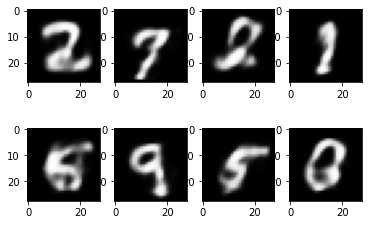

Samples generated from random H1


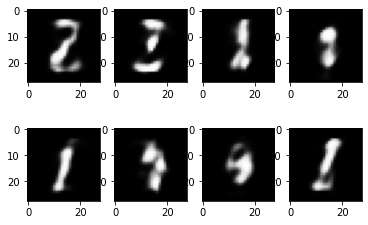

In [10]:
num_steps= 10000 # try different values
n_logging = 1000  # try different values

for step in range(num_steps):
    # -------- train RBM -----#
    batch_x, _= mnist.train.next_batch(batch_size)
    x_g, h1_x = layer0(batch_x)
    
    #  ------- logging -------
    if step%n_logging == 0:
        clear_output()
        print('Samples generated starting from given X')
        
        x_gaux = np.reshape(x_g, [-1,28,28,1])        
        plt.figure(1)
        for i in range(2*4):
            plt.subplot(241 + i)
            plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
        plt.show()
        
        print('Samples generated from random H1')
        
        # random samples from RBM model starting with random h1 samples
        hst = tf.random.uniform(shape=(layer0.batch_size, layer0.n_hidden), minval=0, maxval=1)
        
        for i in range(layer0.k): 
            Xst_prob = tf.sigmoid(tf.matmul(hst, tf.transpose(layer0.w)) + layer0.c)
            Xst = bernoulli_sample_tf(Xst_prob)
            hst_prob = tf.sigmoid(tf.matmul(Xst, layer0.w) + layer0.b)
            hst = bernoulli_sample_tf(hst_prob)
        x_g = tf.sigmoid(tf.matmul(hst, tf.transpose(layer0.w)) + layer0.c) # X generated from random h1
        
        x_gaux = np.reshape(x_g, [-1,28,28,1])
        
        plt.figure(2)
        for i in range(2*4):
            plt.subplot(241 + i)
            plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
        plt.show()

Samples generated starting from given X


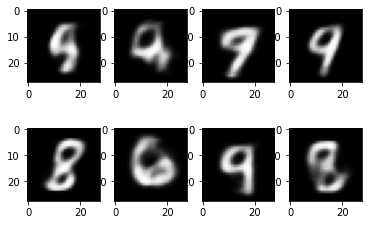

Samples generated from random H2


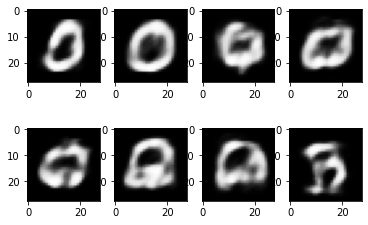

In [11]:
for step in range(num_steps):
    # -------- train RBM -----#
    batch_x, _= mnist.train.next_batch(batch_size)
    x_g, h1_x = layer0(batch_x)
    h1s_prob, h2_h1 = layer1(h1_x)
    x_g = tf.sigmoid(tf.matmul(h1s_prob, tf.transpose(layer0.w)) + layer0.c) # samples given X while training second RBM

    #  ------- logging -------
    if step%n_logging == 0:
        clear_output()
        print('Samples generated starting from given X')
        x_gaux = np.reshape(x_g, [-1,28,28,1])
        
        plt.figure(1)
        for i in range(2*4):
            plt.subplot(241 + i)
            plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
        plt.show()
        
        print('Samples generated from random H2')
        
        # random samples from RBM model starting with random h2 samples
        h2st = tf.random.uniform(shape=(layer1.batch_size, layer1.n_hidden), minval=0, maxval=1)
        for i in range(layer1.k): 
            h1st_prob = tf.sigmoid(tf.matmul(h2st, tf.transpose(layer1.w)) + layer1.c)
            h1st = bernoulli_sample_tf(h1st_prob)
            h2st_prob = tf.sigmoid(tf.matmul(h1st, layer1.w) + layer1.b)
            h2st = bernoulli_sample_tf(h2st_prob)
        x_g = tf.sigmoid(tf.matmul(h1st, tf.transpose(layer0.w)) + layer0.c) # X generated from random h2
        
        x_gaux = np.reshape(x_g, [-1,28,28,1])
        
        plt.figure(2)
        for i in range(2*4):
            plt.subplot(241 + i)
            plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
        plt.show()